In [1]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
import logging
from utils.logger_utils import setup_clean_logger, mute_external_loggers

# Set up a clean logger for your notebook
logger = setup_clean_logger("notebook", logging.INFO)
logger.info("Notebook started successfully.")

# Mute logs from sisepuede to avoid duplication
mute_external_loggers(["sisepuede"])


##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

2025-07-25 12:40:09,312 - INFO - Notebook started successfully.


In [2]:
%load_ext autoreload
%autoreload 2

## Initial Set up

In [3]:
# Set up dir paths

CURR_DIR_PATH = pathlib.Path(os.getcwd())
SSP_MODELING_DIR_PATH = CURR_DIR_PATH.parent
PROJECT_DIR_PATH = SSP_MODELING_DIR_PATH.parent
DATA_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("input_data")
RUN_OUTPUT_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("ssp_run_output")
TRANSFORMATIONS_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("transformations")
STRATEGIES_DEFINITIONS_FILE_PATH = TRANSFORMATIONS_DIR_PATH.joinpath("strategy_definitions.csv")

In [4]:
# NOTE: DO NOT MODIFY

# Set up SSP objects
file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

In [5]:
# Set to True if you want to use the energy model, othwerwise set to False
energy_model_flag = False

## Load Input Data

The lines below load an example DataFrame. However, if you want to run data for a specific country, make sure to load the input data from a CSV file using pandas.


In [6]:
# Load sisepuede input data frame
examples = SISEPUEDEExamples()
df_inputs = examples.input_data_frame

# Example of loading a specific country data from a CSV file
# df_inputs = pd.read_csv(DATA_DIR_PATH.joinpath("example_country_data.csv"))

In [7]:
# Check the df_inputs data frame
df_inputs.head()

,region,time_period,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,avgmass_lvst_animal_chickens_kg,...,ef_ippu_tonne_cf4_per_tonne_production_electronics,ef_ippu_tonne_cf4_per_tonne_production_metals,ef_ippu_tonne_c3f8_per_tonne_production_chemicals,ef_ippu_tonne_c3f8_per_tonne_production_electronics,ef_ippu_tonne_c4f10_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c4f10_per_tonne_production_chemicals,ef_ippu_tonne_c6f14_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c6f14_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_electronics
0,costa_rica,0,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,4.204879e-07,0.0,1.515048e-07,0.0,0.0,0.0,0.0,0.0,5.669821e-08
1,costa_rica,1,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.134675e-07,0.0,1.313925e-07,0.0,0.0,0.0,0.0,0.0,5.185820e-08
2,costa_rica,2,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,1.821067e-07,0.0,1.060066e-07,0.0,0.0,0.0,0.0,0.0,5.269348e-08
3,costa_rica,3,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.094712e-07,0.0,1.093024e-07,0.0,0.0,0.0,0.0,0.0,5.500450e-08
4,costa_rica,4,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,3.446161e-07,0.0,1.046451e-07,0.0,0.0,0.0,0.0,0.0,5.266081e-08


In [8]:
# NOTE: DO NOT MODIFY
# Get region name
region_name = df_inputs["region"].unique()[0]
region_name

'costa_rica'

##  Building Transformations


In [9]:
# NOTE: DO NOT MODIFY

# Loads df_inputs to transformers
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs,
)

###  Instantiate some transformations

A directory named **`transformations`** will be created. It includes the configuration files for each standard transformation, as well as a CSV file containing the strategies.


In [10]:
# NOTE: DO NOT MODIFY

# set an ouput path and instantiate
if not TRANSFORMATIONS_DIR_PATH.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        TRANSFORMATIONS_DIR_PATH,
    )
else:
    logger.info(f"Directory {TRANSFORMATIONS_DIR_PATH} already exists. Skipping instantiation.")


2025-07-25 12:40:12,611 - INFO - Directory /home/tony-ubuntu/decision_sciences/ssp_example/ssp_modeling/transformations already exists. Skipping instantiation.


### Set up the strategies to run

To check the list of available strategies, go to [strategy_definitions.csv](../transformations/strategy_definitions.csv) in the `transformations` directory.

In [11]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 1000]

### We finished setting up transformations and strategies so lets load them to the transformations object

In [12]:
# NOTE: DO NOT MODIFY
transformations = trf.Transformations(
    TRANSFORMATIONS_DIR_PATH,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [13]:
# NOTE: DO NOT MODIFY

#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

Strategies defined at /home/tony-ubuntu/decision_sciences/ssp_example/ssp_modeling/transformations initialized in 2.9 seconds


In [14]:
# NOTE: DO NOT MODIFY

# Check the strategies attribute table to confirm the strategies were built correctly
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
64,4005,IPPU:DEC_PFCS,Singleton - Default Value - IPPU: Reduce use o...,NaN,TX:IPPU:DEC_PFCS,0
65,4006,IP:ALL,Sectoral Composite - IPPU,All (unique by transformer) IPPU transformations,TX:IPPU:DEC_CLINKER|TX:IPPU:DEC_DEMAND|TX:IPPU...,0
66,6000,PFLO:INC_HEALTHIER_DIETS,Singleton - Default Value - PFLO: Change diets,NaN,TX:PFLO:INC_HEALTHIER_DIETS,0
67,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0


##  Build our templates


In [15]:
# NOTE: DO NOT MODIFY

# Building excel templates
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

starting strat 1000 with input shape (36, 2219)
strat 1000 with output shape (36, 2219)
here = 1000


0

## Finally, load SISEPUEDE and run it

In [16]:
# NOTE: DO NOT MODIFY

import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    # id_str = f"sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = not(energy_model_flag),
    regions = [region_name],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2025-07-25 12:40:20,340 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-07-25 12:40:20,343 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-07-25 12:40:20,344 - INFO - 	Setting export engine to 'csv'.
2025-07-25 12:40:20,345 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-07-25 12:40:20,345 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-07-25 12:40:20,346 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-07-25 12:40:20,346 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-07-25 12:40:20,347 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-07-25 12:40:20,347 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-07-25 12:40:20,348 - WARNING - No index fi

In [17]:
# NOTE: DO NOT MODIFY

# This runs the model
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
    include_electricity_in_energy = energy_model_flag
)

2025-07-25 12:40:49,635 - INFO - 
***	STARTING REGION costa_rica	***

2025-07-25 12:40:53,777 - INFO - Trying run primary_id = 0 in region costa_rica
2025-07-25 12:40:53,778 - INFO - Running AFOLU model
2025-07-25 12:40:53,971 - INFO - AFOLU model run successfully completed
2025-07-25 12:40:53,972 - INFO - Running CircularEconomy model
2025-07-25 12:40:54,028 - INFO - CircularEconomy model run successfully completed
2025-07-25 12:40:54,029 - INFO - Running IPPU model
2025-07-25 12:40:54,121 - INFO - IPPU model run successfully completed
2025-07-25 12:40:54,122 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-07-25 12:40:54,148 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-07-25 12:40:54,256 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-07-25 12:40:54,257 - INFO - Running Energy (Fugitive Emissions)
2025-07-25 12:40:54

{'costa_rica': [0, 1001]}

## Check and Save Resutls

The output DataFrames will include a **`primary_id`** field that identifies the strategy run. To match **`primary_id`** with **`strategy_id`**, refer to the **`ATTRIBUTE_PRIMARY.csv`** file.


In [18]:
# NOTE: DO NOT MODIFY

# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

In [19]:
df_in.head()

,primary_id,region,time_period,area_gnrl_country_ha,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,...,yf_agrc_fruits_tonne_ha,yf_agrc_herbs_and_other_perennial_crops_tonne_ha,yf_agrc_nuts_tonne_ha,yf_agrc_other_annual_tonne_ha,yf_agrc_other_woody_perennial_tonne_ha,yf_agrc_pulses_tonne_ha,yf_agrc_rice_tonne_ha,yf_agrc_sugar_cane_tonne_ha,yf_agrc_tubers_tonne_ha,yf_agrc_vegetables_and_vines_tonne_ha
0,0,costa_rica,0,13565900.0,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,...,20.037589,12.059233,2.946800,6.177415,0.0,2.755621,8.636027,73.140598,37.547100,28.821448
1,0,costa_rica,1,13565900.0,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,...,20.479993,12.539800,3.455483,7.165802,0.0,3.259699,8.228317,71.163825,39.000100,29.765171
2,0,costa_rica,2,13565900.0,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,...,19.994821,12.161233,3.041817,11.119348,0.0,3.958685,8.302446,89.448975,39.119475,28.720595
3,0,costa_rica,3,13565900.0,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,...,18.948929,12.289167,3.375283,5.436126,0.0,4.167037,8.846059,90.190264,37.352525,29.482348
4,0,costa_rica,4,13565900.0,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,...,20.238607,12.337700,2.992183,6.177415,0.0,3.226093,7.882382,84.012849,38.551850,32.769776


In [20]:
df_out.head()

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
0,0,costa_rica,0,0.0,367983.831774,68239.857458,80.234375,79198.541655,6714.566582,1.154590e+06,...,1607.703461,955073.693482,19786.484805,7.132381e+06,0.0,985.642069,2.422231e+06,2.104457e+07,166526.651285,147.841681
1,0,costa_rica,1,0.0,362385.636787,67201.713944,79.013757,77993.681983,6612.416842,1.137025e+06,...,1618.201188,978025.173334,22849.096189,8.147695e+06,0.0,1148.204785,2.272766e+06,2.016430e+07,170339.476720,150.359797
2,0,costa_rica,2,0.0,361096.126663,66962.583908,78.732596,77716.149895,6588.887271,1.132979e+06,...,1574.244188,945124.232643,20042.187116,1.259799e+07,0.0,1389.455885,2.285081e+06,2.525521e+07,170252.877121,144.566821
3,0,costa_rica,3,0.0,359935.747562,66747.400257,78.479589,77466.409758,6567.713942,1.129338e+06,...,1487.104127,951997.620585,22167.895406,6.139224e+06,0.0,1457.885138,2.426876e+06,2.538268e+07,162040.494052,147.924261
4,0,costa_rica,4,0.0,358773.521179,66531.874041,78.226180,77216.272044,6546.506906,1.125692e+06,...,1583.188921,952671.199593,19588.348855,6.953864e+06,0.0,1125.040763,2.155513e+06,2.356779e+07,166703.308298,163.887648


In [21]:
df_out.tail()

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
67,1001,costa_rica,31,0.0,303163.679345,56219.443569,66.101134,65247.761488,5531.799320,951209.515396,...,1281.245822,784484.589852,16315.161105,6.011617e+06,0.0,1006.647980,1.946255e+06,2.117636e+07,145918.306196,130.609377
68,1001,costa_rica,32,0.0,301300.908477,55874.006603,65.694979,64846.850569,5497.809514,945364.866134,...,1273.373285,779664.371798,16214.913585,5.974679e+06,0.0,1000.462693,1.934296e+06,2.104624e+07,145021.720001,129.806855
69,1001,costa_rica,33,0.0,299451.212856,55530.994344,65.291676,64448.753742,5464.058291,939561.241904,...,1265.556007,774877.988041,16115.369728,5.938000e+06,0.0,994.320821,1.922421e+06,2.091704e+07,144131.427164,129.009967
70,1001,costa_rica,34,0.0,297614.496293,55190.388954,64.891202,64053.450306,5430.543895,933798.340901,...,1257.793582,770125.189676,16016.524356,5.901579e+06,0.0,988.222046,1.910630e+06,2.078874e+07,143247.381389,128.218670
71,1001,costa_rica,35,0.0,295790.663331,54852.172732,64.493538,63660.919715,5397.264586,928075.863621,...,1250.085606,765405.729694,15918.372333,5.865413e+06,0.0,982.166051,1.898921e+06,2.066135e+07,142369.536731,127.432924


### Plot Outputs

In [22]:
# NOTE: DO NOT MODIFY

def plot_field_stack(
    df,
    fields,
    dict_format,
    time_col="time_period",
    primary_id=0,
    figsize=(18, 8),
    legend_loc='upper right',
    legend_bbox=(1.1, 1),
    ylabel="MT Emissions CO2e",
    xlabel="Time Period",
    title=None,
):
    """
    Plots a stack plot of the selected fields for a given primary_id.

    Args:
        df (pd.DataFrame): DataFrame containing output data.
        fields (list): List of column names to plot.
        dict_format (dict): Formatting dictionary for colors.
        time_col (str): Name of the time column.
        primary_id (int): Value of primary_id to filter.
        figsize (tuple): Figure size.
        legend_loc (str): Legend location.
        legend_bbox (tuple): Legend bbox_to_anchor.
        ylabel (str): Y-axis label.
        xlabel (str): X-axis label.
        title (str): Plot title.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)

    df_plot = df[df[ssp.key_primary].isin([primary_id])]

    fig, ax = spu.plot_stack(
        df_plot,
        fields,
        dict_formatting=dict_format,
        field_x=time_col,
        figtuple=(fig, ax),
    )

    ax.legend(loc=legend_loc, bbox_to_anchor=legend_bbox, title="Fields")
    plt.show()

In [23]:
# NOTE: DO NOT MODIFY

# Define the fields to plot and the formatting dictionary
subsector_emission_fields = matt.get_all_subsector_emission_total_fields()

dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

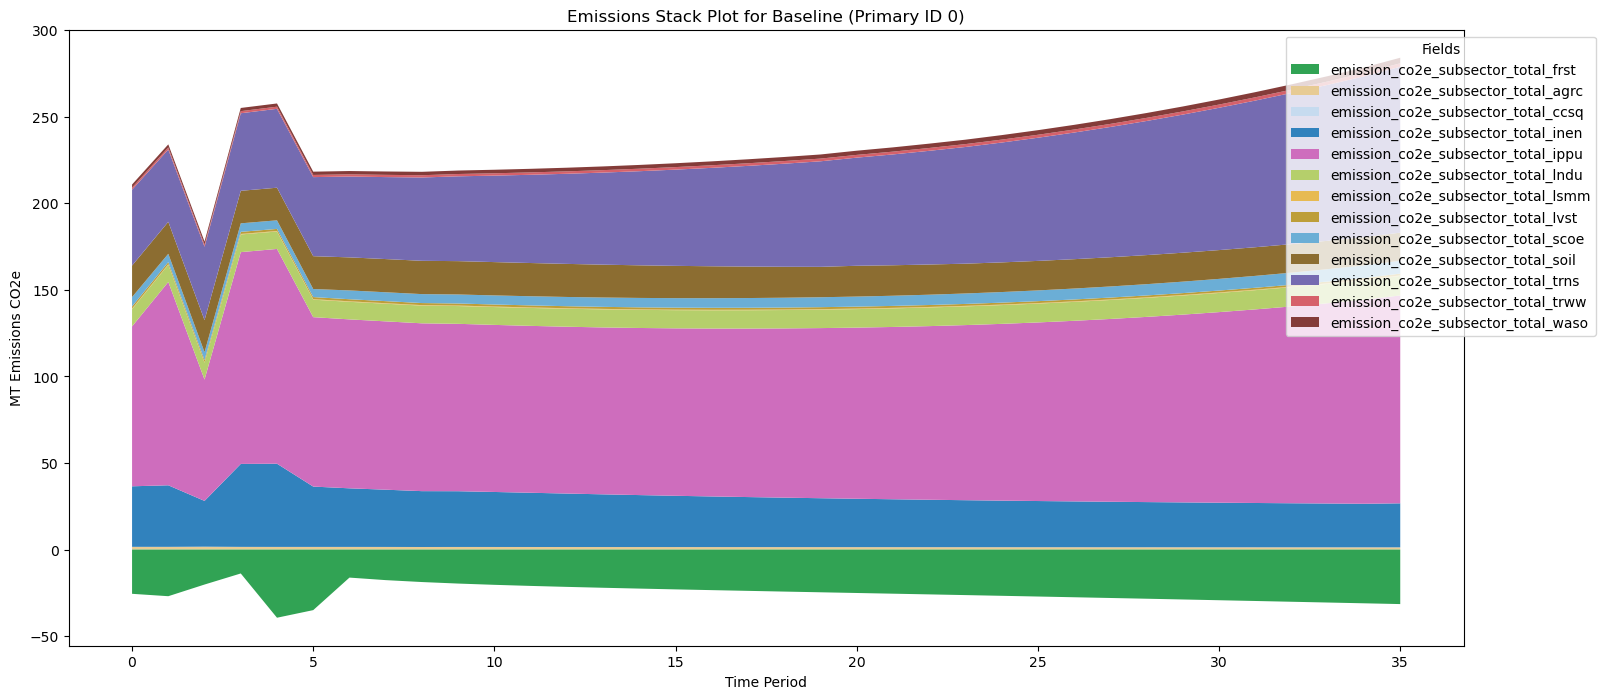

In [24]:
# Plot the emissions stack for the primary_id 0 (which is the baseline)
plot_field_stack(
    df_out,
    subsector_emission_fields,
    dict_format,
    primary_id=0,
    title="Emissions Stack Plot for Baseline (Primary ID 0)"
)

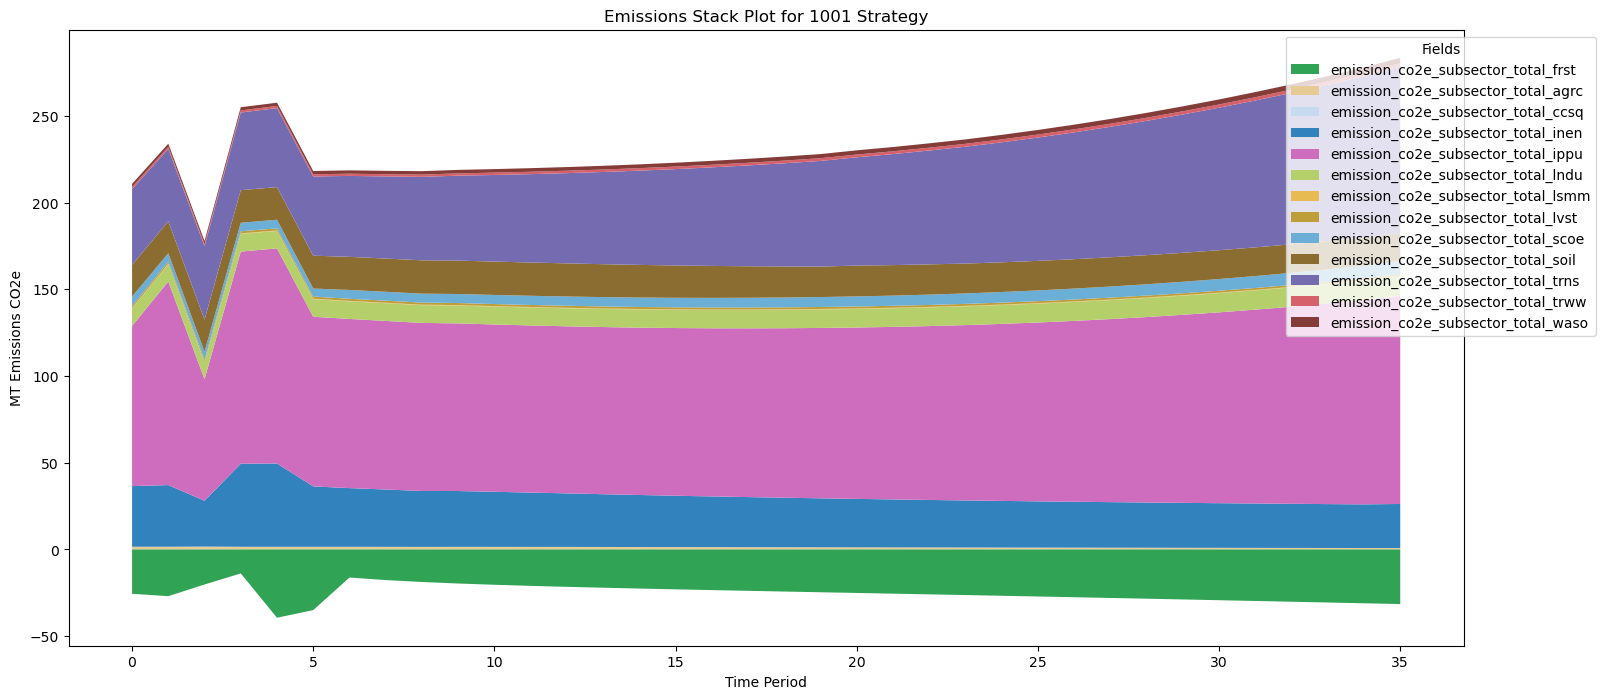

In [25]:
# You can add another plot for a different primary_id, e.g., 1001

plot_field_stack(
    df_out,
    subsector_emission_fields,
    dict_format,
    primary_id=1001,
    title="Emissions Stack Plot for 1001 Strategy"
)

### Export Files

In [27]:
# NOTE: DO NOT MODIFY

all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [28]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/home/tony-ubuntu/anaconda3/envs/ssp_example_env/lib/python3.11/site-packages/sisepuede/out'

In [29]:
# NOTE: DO NOT MODIFY

RUN_ID_OUTPUT_DIR_PATH = os.path.join(
    RUN_OUTPUT_DIR_PATH, 
    f"sisepuede_results_run_{ssp.id_fs_safe}"
)

os.makedirs(RUN_ID_OUTPUT_DIR_PATH, exist_ok=True)

df_primary.to_csv(
    os.path.join(RUN_ID_OUTPUT_DIR_PATH, "ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(RUN_ID_OUTPUT_DIR_PATH, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(RUN_ID_OUTPUT_DIR_PATH, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        logger.warning(f"Warning: Table {tab} returned None.")